In [3]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
from IPython.display import Image, display
import PIL
from PIL import ImageOps



In [4]:
physical_device=tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available=  ", len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0], True)

Num GPUs Available=   0


IndexError: list index out of range

In [2]:

input_dir = "E:\\My papers\\pneumothorax segmentation\\Unet\\train\\image"
target_dir = "E:\\My papers\\pneumothorax segmentation\\Unet\\train\\mask"
img_size = (128, 128)
num_classes = 2
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 12715
E:\My papers\pneumothorax segmentation\Unet\train\image\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.jpg | E:\My papers\pneumothorax segmentation\Unet\train\mask\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.jpg
E:\My papers\pneumothorax segmentation\Unet\train\image\1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.jpg | E:\My papers\pneumothorax segmentation\Unet\train\mask\1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.jpg
E:\My papers\pneumothorax segmentation\Unet\train\image\1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.jpg | E:\My papers\pneumothorax segmentation\Unet\train\mask\1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.jpg
E:\My papers\pneumothorax segmentation\Unet\train\image\1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.jpg | E:\My papers\pneumothorax segmentation\Unet\train\mask\1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.jpg
E:\My papers\pneumothorax segmentation\Unet\t

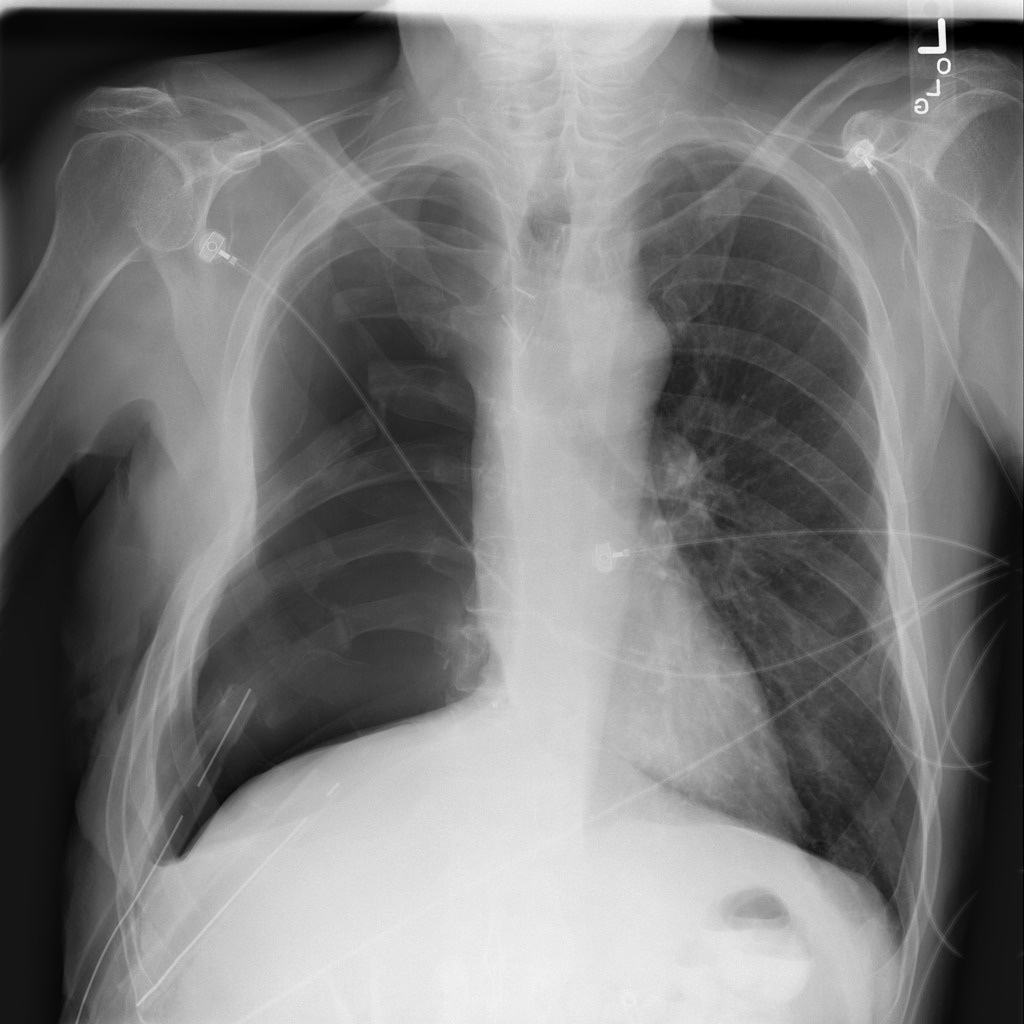

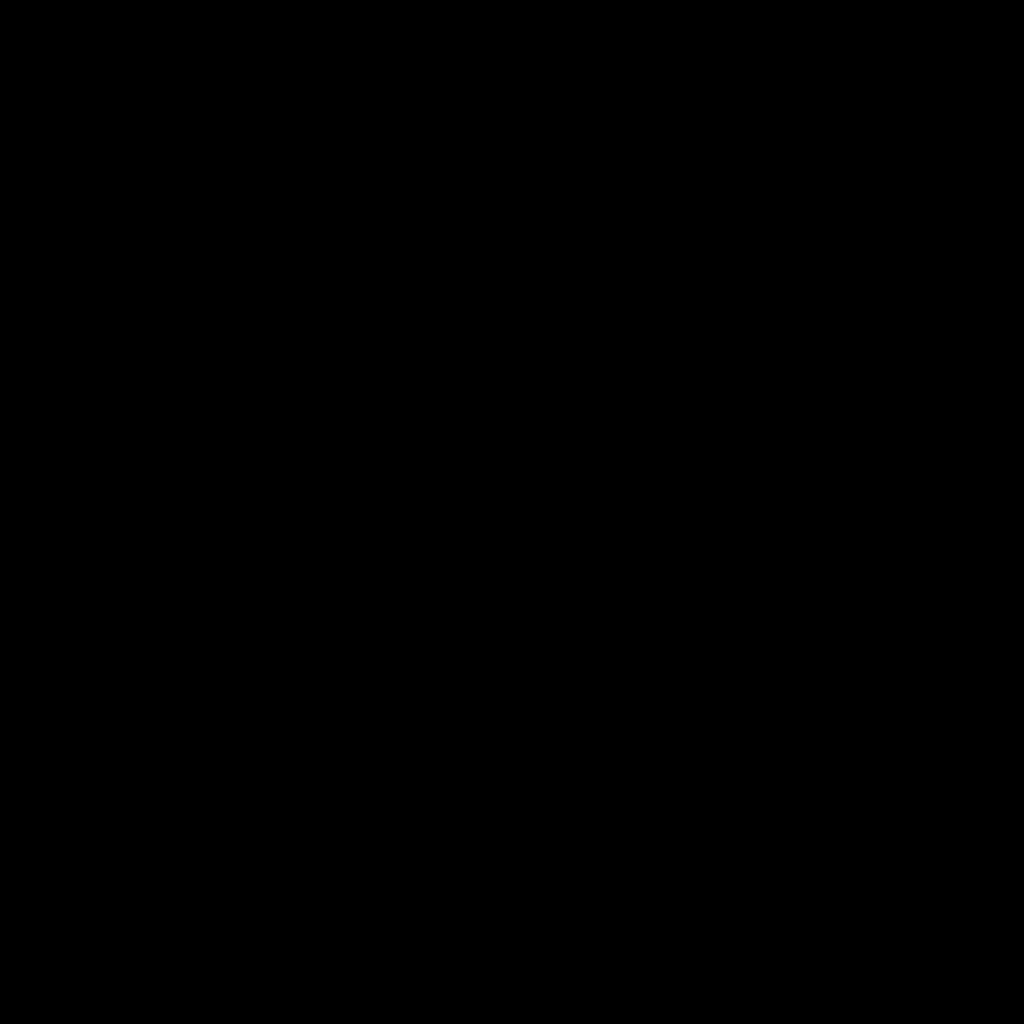

In [3]:
# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [4]:
class Data_gen(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j]=y[j]/255
        return x, y

In [5]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Data_gen(batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = Data_gen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [6]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
opt=keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",)

callbacks = [keras.callbacks.ModelCheckpoint("First_model_save.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 1
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

332/332 [==============================] - 3116s 9s/step - loss: 0.0808 - val_loss: 0.0782


In [ ]:
val_preds = model.predict(val_gen)

In [24]:

def display_mask(i):
    """Quick utility to display a model's prediction."""

    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    print(mask.shape)



Input Image


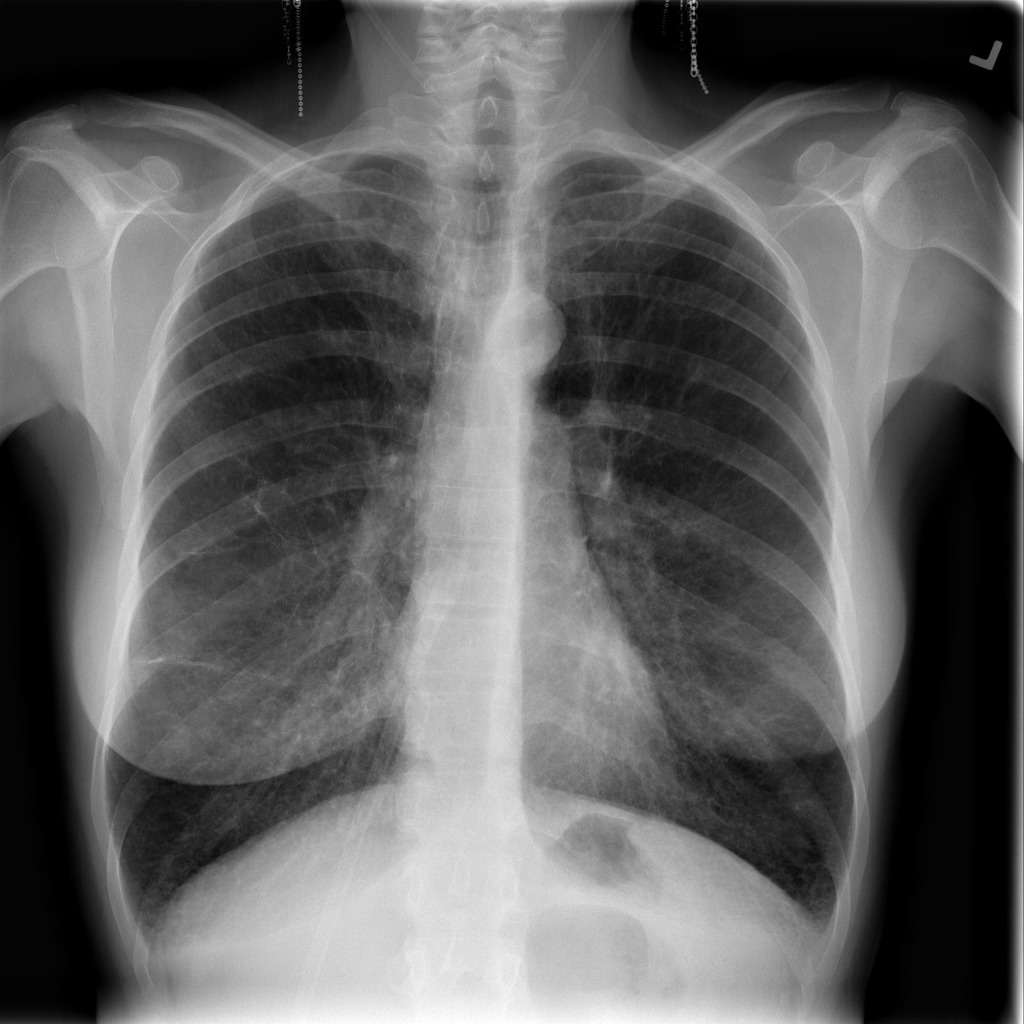

Ground Truth


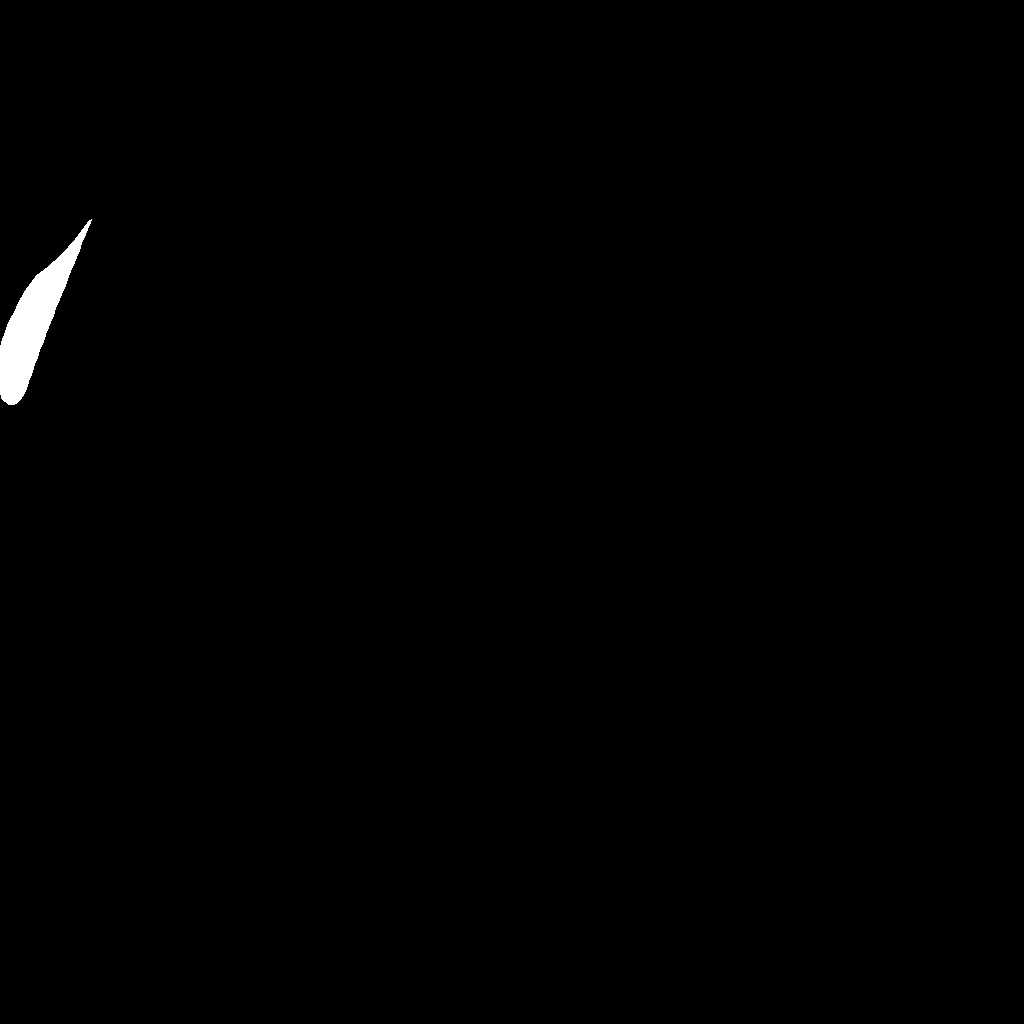

Prediction


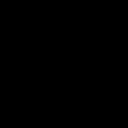

(128, 128, 1)


In [25]:
# Display results for validation image #10
i = 1

# Display input image
print("Input Image")
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
print("Ground Truth")
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

print("Prediction")
# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs